In [1]:
"""!pip install torch==0.4.1 torchvision"""

'!pip install torch==0.4.1 torchvision'

In [2]:
"""!pip install Pillow==4.0.0
!pip install PIL
!pip install image"""

'!pip install Pillow==4.0.0\n!pip install PIL\n!pip install image'

In [3]:
"""!wget https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip -e flower_data.zip"""

'!wget https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json\n!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip\n!unzip -e flower_data.zip'

# import

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.models as models
from tqdm import tqdm
import json
import time
import copy

## image path

In [5]:
data_dir = './flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

## load data

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),#RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.CenterCrop((500,500)),
        transforms.Resize(256),
        transforms.CenterCrop(224),#transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.CenterCrop((500,500)),
        transforms.Resize(256),
        transforms.CenterCrop(224),#transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


# TODO: Load the datasets with ImageFolder
image_datasets={'train':torchvision.datasets.ImageFolder(train_dir, transform=data_transforms['train']),
                'valid':torchvision.datasets.ImageFolder(valid_dir, transform=data_transforms['val']),
               'test':torchvision.datasets.ImageFolder(test_dir, transform=data_transforms['test'])}

# TODO: Using the image datasets and the trainforms, define the dataloaders
loader={'train':torch.utils.data.DataLoader(image_datasets['train'], shuffle=True, batch_size=4, num_workers=4),
       'valid':torch.utils.data.DataLoader(image_datasets['valid'], shuffle=True, batch_size=4, num_workers=4),
       'test':torch.utils.data.DataLoader(image_datasets['test'], shuffle=True, batch_size=4, num_workers=4)}
num_train = len(image_datasets['train'])
print(num_train)

6552


## Label mapping

In [7]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
label_map=cat_to_name
#image_datasets['train'].class_to_idx=cat_to_name
#image_datasets['valid'].class_to_idx=cat_to_name

In [8]:
#image_datasets['valid'].class_to_idx

## Model

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet18(pretrained=True)#models.vgg19(pretrained=True)
#print(model)

in_features=model.fc.in_features

In [10]:
for param in model.fc.parameters():
    param.requires_grad = False

In [11]:
model.fc = nn.Linear(in_features, 102)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [12]:
#model.class_to_idx = image_datasets['train'].class_to_idx

In [13]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid','test']}

# Train

In [14]:
namefile="model_image-new"
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_losses, valid_losses,test_losses = [], [],[]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid','test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            validloader = tqdm(loader[phase], total=len(loader[phase]))
            for inputs, labels in validloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                train_losses.append(epoch_loss)
            elif phase == 'valid':
                valid_losses.append(epoch_loss)
            else:
                test_losses.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            torch.save(model.state_dict(), namefile+".ep"+str(epoch+1)+".model")
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_losses, valid_losses,test_losses

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model,train_losses, valid_losses,test_losses = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

  0%|          | 0/1638 [00:00<?, ?it/s]

Epoch 0/24
----------


100%|██████████| 1638/1638 [02:56<00:00,  9.39it/s]


train Loss: 2.5656 Acc: 0.4090


100%|██████████| 205/205 [00:07<00:00, 29.24it/s]


valid Loss: 0.6524 Acc: 0.8227


  0%|          | 0/1638 [00:00<?, ?it/s]

test Loss: 0.7735 Acc: 0.7827

Epoch 1/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 1.3014 Acc: 0.6732


100%|██████████| 205/205 [00:06<00:00, 32.45it/s]


valid Loss: 0.3048 Acc: 0.9144


100%|██████████| 205/205 [00:06<00:00, 29.99it/s]


test Loss: 0.3293 Acc: 0.9011


  0%|          | 0/1638 [00:00<?, ?it/s]


Epoch 2/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.9529 Acc: 0.7582


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.2211 Acc: 0.9352


100%|██████████| 205/205 [00:06<00:00, 36.74it/s]


test Loss: 0.2664 Acc: 0.9280


  0%|          | 0/1638 [00:00<?, ?it/s]


Epoch 3/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.8493 Acc: 0.7788


100%|██████████| 205/205 [00:06<00:00, 32.21it/s]


valid Loss: 0.2443 Acc: 0.9364


100%|██████████| 205/205 [00:06<00:00, 33.17it/s]


test Loss: 0.2472 Acc: 0.9414


  0%|          | 0/1638 [00:00<?, ?it/s]


Epoch 4/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.7487 Acc: 0.8118


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.2636 Acc: 0.9291


100%|██████████| 205/205 [00:05<00:00, 34.65it/s]


test Loss: 0.2772 Acc: 0.9231


  0%|          | 0/1638 [00:00<?, ?it/s]


Epoch 5/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.6401 Acc: 0.8393


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.2073 Acc: 0.9548


  0%|          | 0/1638 [00:00<?, ?it/s]

test Loss: 0.2096 Acc: 0.9487

Epoch 6/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.5807 Acc: 0.8494


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.1563 Acc: 0.9584


  0%|          | 0/1638 [00:00<?, ?it/s]

test Loss: 0.1647 Acc: 0.9548

Epoch 7/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.4441 Acc: 0.8927


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.1328 Acc: 0.9670


100%|██████████| 205/205 [00:06<00:00, 36.16it/s]


test Loss: 0.1319 Acc: 0.9731


  0%|          | 0/1638 [00:00<?, ?it/s]


Epoch 8/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.3800 Acc: 0.9057


100%|██████████| 205/205 [00:06<00:00, 33.61it/s]


valid Loss: 0.1144 Acc: 0.9707


100%|██████████| 205/205 [00:05<00:00, 34.19it/s]


test Loss: 0.1188 Acc: 0.9707


  0%|          | 0/1638 [00:00<?, ?it/s]


Epoch 9/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.3533 Acc: 0.9164


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.1081 Acc: 0.9670


  0%|          | 0/1638 [00:00<?, ?it/s]

test Loss: 0.1322 Acc: 0.9695

Epoch 10/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.3408 Acc: 0.9161


100%|██████████| 205/205 [00:05<00:00, 34.50it/s]


valid Loss: 0.1096 Acc: 0.9719


  0%|          | 0/1638 [00:00<?, ?it/s]

test Loss: 0.1254 Acc: 0.9707

Epoch 11/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.3229 Acc: 0.9220


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.0987 Acc: 0.9731


100%|██████████| 205/205 [00:05<00:00, 37.47it/s]


test Loss: 0.1191 Acc: 0.9707


  0%|          | 0/1638 [00:00<?, ?it/s]


Epoch 12/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.3244 Acc: 0.9219


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.0971 Acc: 0.9743


  0%|          | 0/1638 [00:00<?, ?it/s]

test Loss: 0.1118 Acc: 0.9768

Epoch 13/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.3114 Acc: 0.9231


100%|██████████| 205/205 [00:05<00:00, 35.61it/s]


valid Loss: 0.1022 Acc: 0.9719


  0%|          | 0/1638 [00:00<?, ?it/s]

test Loss: 0.1171 Acc: 0.9744

Epoch 14/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.3065 Acc: 0.9299


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.0871 Acc: 0.9780


100%|██████████| 205/205 [00:05<00:00, 37.69it/s]


test Loss: 0.1154 Acc: 0.9731


  0%|          | 0/1638 [00:00<?, ?it/s]


Epoch 15/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.2996 Acc: 0.9321


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.0958 Acc: 0.9731


  0%|          | 0/1638 [00:00<?, ?it/s]

test Loss: 0.1137 Acc: 0.9707

Epoch 16/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.2797 Acc: 0.9332


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.0938 Acc: 0.9756


100%|██████████| 205/205 [00:05<00:00, 37.54it/s]


test Loss: 0.1149 Acc: 0.9768


  0%|          | 0/1638 [00:00<?, ?it/s]


Epoch 17/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.2822 Acc: 0.9319


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.1034 Acc: 0.9707


  0%|          | 0/1638 [00:00<?, ?it/s]

test Loss: 0.1165 Acc: 0.9731

Epoch 18/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.2721 Acc: 0.9351


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.1064 Acc: 0.9707


  0%|          | 0/1638 [00:00<?, ?it/s]

test Loss: 0.1122 Acc: 0.9756

Epoch 19/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.2934 Acc: 0.9283


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.0965 Acc: 0.9780


100%|██████████| 205/205 [00:05<00:00, 37.72it/s]


test Loss: 0.1241 Acc: 0.9744


  0%|          | 0/1638 [00:00<?, ?it/s]


Epoch 20/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.2931 Acc: 0.9293


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.0976 Acc: 0.9743


  0%|          | 0/1638 [00:00<?, ?it/s]

test Loss: 0.1235 Acc: 0.9707

Epoch 21/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.2822 Acc: 0.9303


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.1001 Acc: 0.9731


100%|██████████| 205/205 [00:05<00:00, 34.71it/s]


test Loss: 0.1124 Acc: 0.9744


  0%|          | 0/1638 [00:00<?, ?it/s]


Epoch 22/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.2890 Acc: 0.9310


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.0878 Acc: 0.9768


  0%|          | 0/1638 [00:00<?, ?it/s]

test Loss: 0.1111 Acc: 0.9744

Epoch 23/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.2987 Acc: 0.9277


100%|██████████| 205/205 [00:05<00:00, 35.62it/s]


valid Loss: 0.0912 Acc: 0.9792


  0%|          | 0/1638 [00:00<?, ?it/s]

test Loss: 0.1083 Acc: 0.9744

Epoch 24/24
----------


  0%|          | 0/205 [00:00<?, ?it/s]

train Loss: 0.2978 Acc: 0.9257


  0%|          | 0/205 [00:00<?, ?it/s]

valid Loss: 0.0953 Acc: 0.9768


100%|██████████| 205/205 [00:05<00:00, 37.44it/s]


test Loss: 0.1131 Acc: 0.9756

Training complete in 77m 43s
Best val Acc: 0.979218


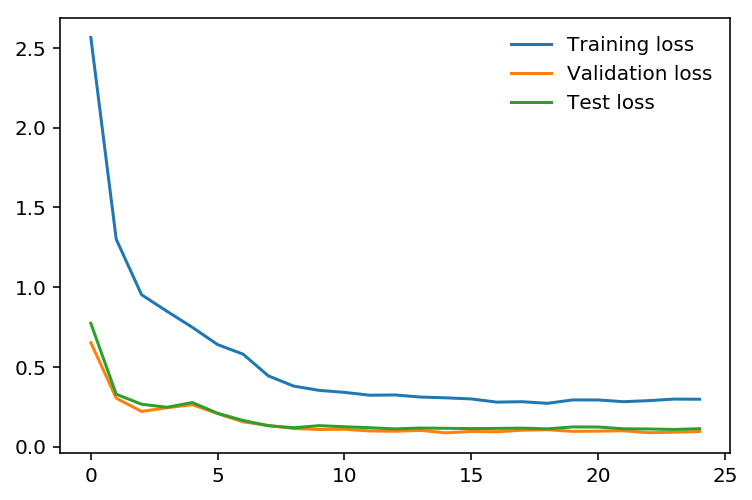

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.plot(test_losses, label='Test loss')
plt.legend(frameon=False)
plt.show()

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [48]:
model.to(device)
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} image : {}'.format(cat_to_name[str(preds[j].data.cpu()[0].item())],cat_to_name[str(labels.data.cpu()[0].item())]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


/home/wannaphong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


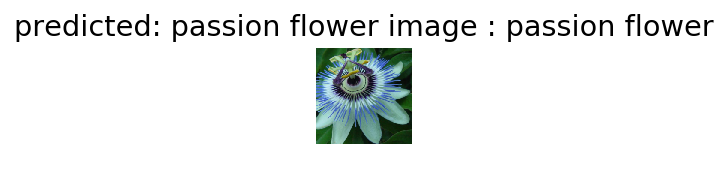

/home/wannaphong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


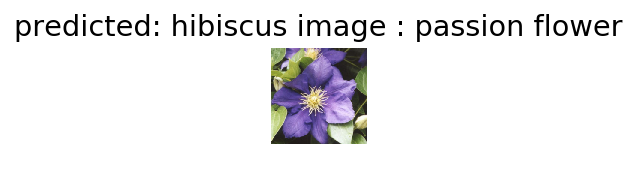

/home/wannaphong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


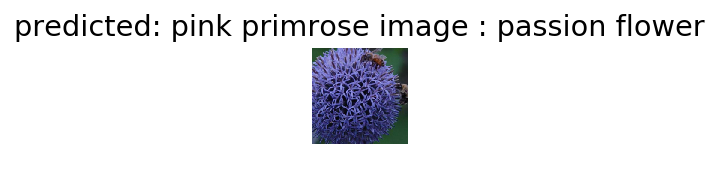

/home/wannaphong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


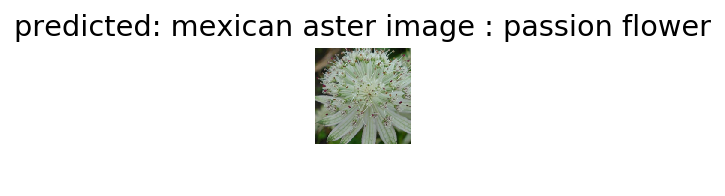

/home/wannaphong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


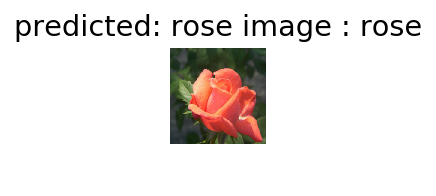

/home/wannaphong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


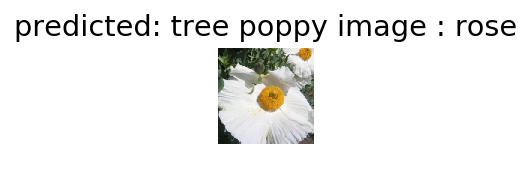

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f319102e208>>
Traceback (most recent call last):
  File "/home/wannaphong/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/wannaphong/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/wannaphong/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/wannaphong/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/wannaphong/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/wannaphong/anaconda3/lib/python3.6/multiprocessing/resour

In [49]:
visualize_model(model)

# Save model

In [19]:
namefile=namefile+'-full2.pth'


model.class_to_idx = image_datasets['train'].class_to_idx
# TODO: Save the checkpoint 
torch.save({'arch': 'resnet18',
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx}, 
            namefile)

In [50]:
model.to('cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [53]:
namefile='full5cpu.pth'


#model.class_to_idx = image_datasets['train'].class_to_idx
# TODO: Save the checkpoint 
torch.save({'arch': 'resnet18',
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx}, 
            namefile)
#model.save_state_dict('mytraining.pt')

In [21]:
def imshow2(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    if title:
        plt.title(title)

    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [22]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)

    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))

    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224

    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

tensor([[[[-1.7583, -1.7240, -1.7240,  ..., -2.0323, -1.9638, -1.9467],
          [-1.3473, -1.2959, -1.4843,  ..., -1.9809, -1.9809, -1.9809],
          [-1.8439, -1.8610, -1.8439,  ..., -1.9295, -1.9638, -1.9638],
          ...,
          [-1.5357, -1.5870, -1.6042,  ..., -1.2274, -1.4843, -1.3130],
          [-1.5870, -1.6042, -1.5870,  ..., -1.4843, -1.5185, -1.2274],
          [-1.8097, -1.7069, -1.6555,  ..., -1.9980, -1.3987, -1.1075]],

         [[-1.4580, -1.4230, -1.4055,  ..., -1.9307, -1.8957, -1.8782],
          [-1.0903, -1.0378, -1.2129,  ..., -1.8782, -1.8782, -1.8606],
          [-1.6506, -1.6506, -1.6506,  ..., -1.8081, -1.7906, -1.7906],
          ...,
          [-1.1779, -1.1779, -1.1779,  ..., -0.7577, -0.9853, -0.8102],
          [-1.3004, -1.2479, -1.2129,  ..., -0.9503, -0.9678, -0.6702],
          [-1.6155, -1.4230, -1.3004,  ..., -1.4755, -0.8277, -0.5476]],

         [[-1.4733, -1.4559, -1.4384,  ..., -1.7696, -1.7522, -1.7347],
          [-1.0201, -0.9678, -

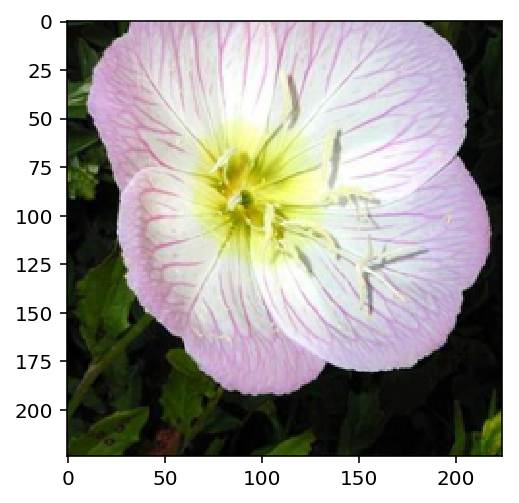

In [26]:
# Process image
image_path=test_dir+"/1/image_06743.jpg"
img = process_image(image_path) 
imshow2(img)
img = torch.from_numpy(img).type(torch.FloatTensor) 
img.unsqueeze_(0)


In [35]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).cpu().type(torch.FloatTensor)#torch.FloatTensor)

    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [label_map[idx_to_class[lab]] for lab in top_labs]

    return top_probs, top_labels, top_flowers

In [38]:
import seaborn as sns
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)

    # Set up title
    flower_num = image_path.split('/')[3]
    title_ = cat_to_name[flower_num]

    # Plot flower
    img = process_image(image_path)
    imshow2(img, ax, title = title_);

    # Make prediction
    probs, labs, flowers = predict(image_path, model) 

    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

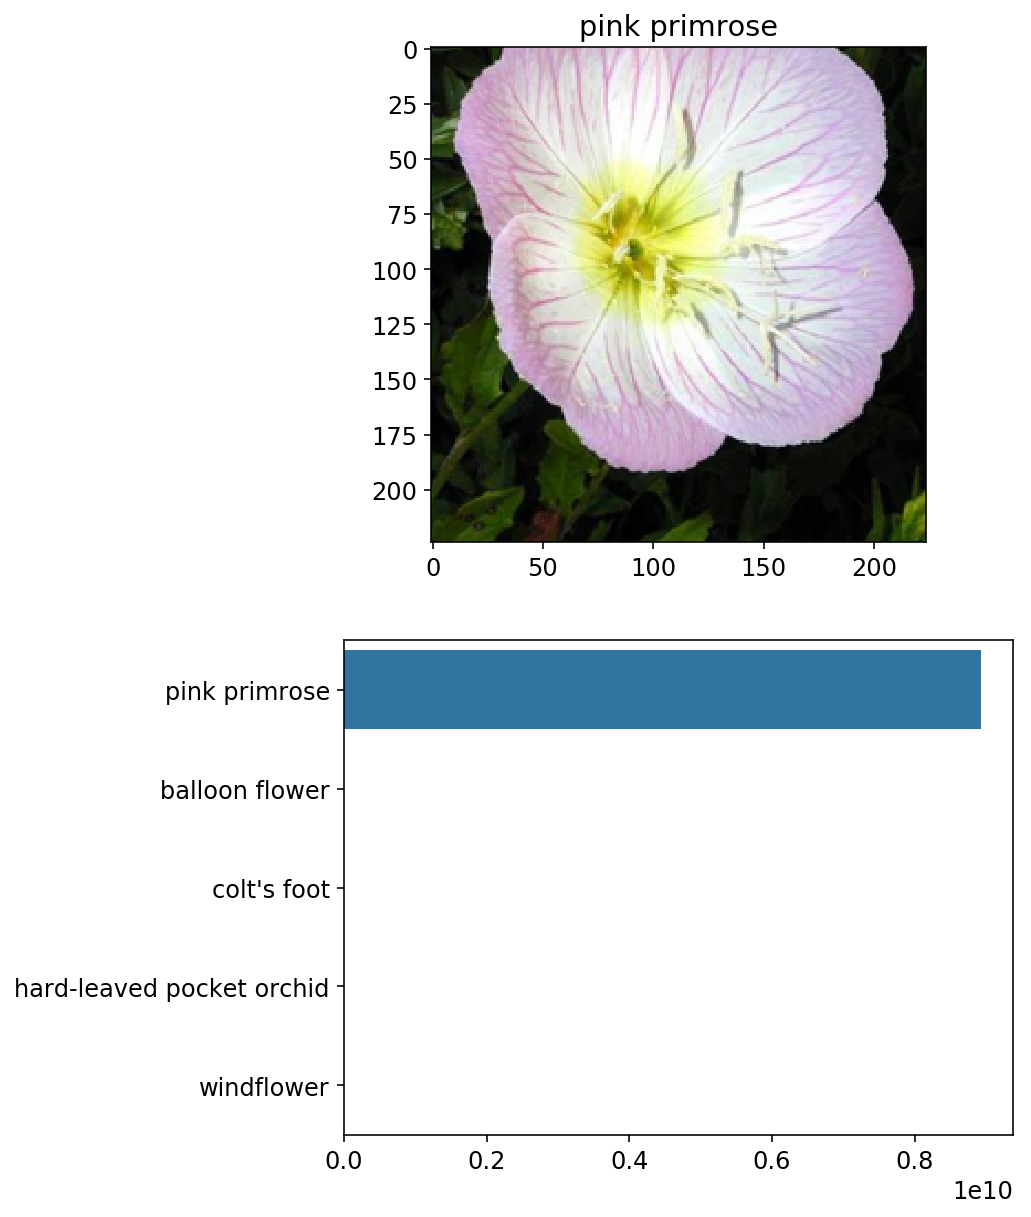

In [39]:
plot_solution(image_path, model)

In [33]:
#model.class_to_idx